In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
lb_make=LabelEncoder()
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.metrics import roc_auc_score


C:\Users\Juba\.conda\envs\py3.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cd C:\adversarial_analysis-master\Investigating_the_Practicality_of_Adversarial_Evasion_Attacks_on_Network_Intrusion_Detection\XAAE-IIoT\ON

C:\adversarial_analysis-master\Investigating_the_Practicality_of_Adversarial_Evasion_Attacks_on_Network_Intrusion_Detection\XAAE-IIoT\ON


In [3]:
# Define device for PyTorch (using GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F

In [4]:
# Load dataset
missing_values = ["n/a", "na", "Infinity", "NaN", "nan", "-", "excel", "?", "#DIV/0!", "aza"]
df = pd.read_csv("df_training.csv", na_values=missing_values, engine='python', skipinitialspace=True)
df = df.fillna(df.median())

normal_data = df[df['class3'] == 0].drop('class3', axis=1)

In [5]:
# Scale the features
scaler = MinMaxScaler()
normal_data_scaled = scaler.fit_transform(normal_data)

# Create PyTorch DataLoader for the normal data
normal_data_tensor = torch.tensor(normal_data_scaled, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(normal_data_tensor, normal_data_tensor), batch_size=32, shuffle=True)

In [5]:
##Section 2: Define the VAE Model

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc21 = nn.Linear(512, latent_dim)  # Mean of the latent space
        self.fc22 = nn.Linear(512, latent_dim)  # Standard deviation of the latent space
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [7]:
def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [8]:
input_dim = normal_data.shape[1]  # Number of features in the normal_data subset
latent_dim = 20  # Example latent dimension size
model = VAE(input_dim, latent_dim)


In [9]:
#Section 3: Define the Planar Flow Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LearnableClamp(nn.Module):
    def __init__(self, initial_min, initial_max):
        super(LearnableClamp, self).__init__()
        # Ensure the parameters are of floating point type
        self.min = nn.Parameter(torch.tensor([initial_min], dtype=torch.float))
        self.max = nn.Parameter(torch.tensor([initial_max], dtype=torch.float))

    def forward(self, x):
        # Apply clamping with learnable min and max
        return torch.clamp(x, min=self.min, max=self.max)

class CouplingFlow(nn.Module):
    def __init__(self, latent_dim, clamp_min=-3.0, clamp_max=3.0):
        super(CouplingFlow, self).__init__()
        self.latent_dim = latent_dim
        mid_dim = latent_dim // 2

        # Layers for the transformation
        self.fc1 = nn.Linear(mid_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.scale_transform = nn.Linear(256, mid_dim)
        self.translate = nn.Linear(256, mid_dim)

        # Learnable clamping for the scale parameter
        self.scale_clamp = LearnableClamp(clamp_min, clamp_max)

        # Initialize a fixed permutation and convert to long tensor
        self.register_buffer('permutation', torch.tensor(np.random.permutation(latent_dim)).long())

    def forward(self, z):
        # Apply permutation
        z = z[:, self.permutation]

        # Split and transform
        z1, z2 = z[:, :self.latent_dim // 2], z[:, self.latent_dim // 2:]
        h = F.relu(self.fc1(z1))
        h = F.relu(self.fc2(h))

        # Apply learnable clamping to the scale parameter
        scale = torch.sigmoid(self.scale_transform(h))
        scale = self.scale_clamp(scale)

        translate = self.translate(h)
        z2 = z2 * scale + translate

        # Combine the two parts
        z_prime = torch.cat([z1, z2], dim=1)

        # Compute log determinant of the Jacobian
        # We add a small constant 1e-6 to the scale before taking log to prevent NaNs
        log_det_jacobian = torch.sum(torch.log(torch.abs(scale) + 1e-6), dim=1)

        return z_prime, log_det_jacobian


In [10]:
class StackedCouplingFlows(nn.Module):
    def __init__(self, latent_dim, num_flows):
        super(StackedCouplingFlows, self).__init__()
        self.flows = nn.ModuleList([CouplingFlow(latent_dim) for _ in range(num_flows)])

    def forward(self, z):
        total_log_det_jacobian = 0
        for flow in self.flows:
            z, log_det_jacobian = flow(z)
            total_log_det_jacobian += log_det_jacobian
        return z, total_log_det_jacobian


In [11]:
# Parameters
latent_dim = 4  # Specify the latent dimension
num_flows = 3   # Number of CouplingFlow layers

# Create the model
model = StackedCouplingFlows(latent_dim=latent_dim, num_flows=num_flows)

# Example input (e.g., a batch of data)
z = torch.randn(10, latent_dim)  # Batch of 10 samples

# Forward pass through the model
z_transformed, total_log_det_jacobian = model(z)


In [13]:
#Section 4: Define the Loss Function

In [12]:
def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [13]:


# NF Loss Function
def nf_loss_function(z, z_prime, log_det_jacobian):
    # Assuming a standard Gaussian for the latent space
    log_pz_prime = -0.5 * (z_prime.pow(2).sum(dim=1) + torch.log(torch.tensor(2 * torch.pi)))

    # Compute the log-likelihood for each transformed data point
    NF_loss = torch.mean(log_pz_prime + log_det_jacobian)

    return -NF_loss  # Negative since we maximize log likelihood


In [16]:
#Section 5: Anomaly Detection Function

In [14]:
def calculate_threshold(differential_entropies):
    mean_entropy = differential_entropies.mean()
    std_entropy = differential_entropies.std()
    threshold = mean_entropy + 2 * std_entropy
    return threshold




In [15]:
vae = VAE(input_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs=10

In [19]:

for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        reconstructed, mu, logvar = vae(data)

        # Compute loss
        loss = vae_loss_function(reconstructed, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


Epoch [1/10], Loss: 182.14016723632812
Epoch [2/10], Loss: 174.82078552246094
Epoch [3/10], Loss: 190.43316650390625
Epoch [4/10], Loss: 182.14254760742188
Epoch [5/10], Loss: 179.39662170410156
Epoch [6/10], Loss: 181.6753387451172
Epoch [7/10], Loss: 185.78692626953125
Epoch [8/10], Loss: 189.75607299804688
Epoch [9/10], Loss: 184.1693115234375
Epoch [10/10], Loss: 171.15621948242188


In [20]:
for param in vae.parameters():
    param.requires_grad = False


In [20]:
''' nf = PlanarFlow(latent_dim).to(device)
optimizer_nf = torch.optim.Adam(nf.parameters(), lr=1e-3)
#nf_epochs=5
for epoch in range(nf_epochs):
    for data, _ in train_loader:
        data = data.to(device)
        with torch.no_grad():
            mu, logvar = vae.encode(data)
            z = vae.reparameterize(mu, logvar)
        
        z_prime, log_det_jacobian = nf(z)
        nf_loss = -torch.mean(log_det_jacobian)
        optimizer_nf.zero_grad()
        nf_loss.backward()
        optimizer_nf.step() '''


' nf = PlanarFlow(latent_dim).to(device)\noptimizer_nf = torch.optim.Adam(nf.parameters(), lr=1e-3)\n#nf_epochs=5\nfor epoch in range(nf_epochs):\n    for data, _ in train_loader:\n        data = data.to(device)\n        with torch.no_grad():\n            mu, logvar = vae.encode(data)\n            z = vae.reparameterize(mu, logvar)\n        \n        z_prime, log_det_jacobian = nf(z)\n        nf_loss = -torch.mean(log_det_jacobian)\n        optimizer_nf.zero_grad()\n        nf_loss.backward()\n        optimizer_nf.step() '

In [16]:
# Instantiate StackedCouplingFlows instead of a single CouplingFlow
nf = StackedCouplingFlows(latent_dim=latent_dim, num_flows=num_flows).to(device)
optimizer_nf = torch.optim.Adam(nf.parameters(), lr=1e-3)

In [21]:

nf_epochs = 10  # Number of epochs for training NF

# Train Normalizing Flow
for epoch in range(nf_epochs):
    total_nf_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer_nf.zero_grad()

        with torch.no_grad():
            mu, logvar = vae.encode(data)
            z = vae.reparameterize(mu, logvar)
        
        # Forward pass through the stacked NF model
        z_prime, total_log_det_jacobian = nf(z)

        # Compute NF loss using the modified loss function
        nf_loss = nf_loss_function(z, z_prime, total_log_det_jacobian)

        # Backward pass and optimize
        nf_loss.backward()
        optimizer_nf.step()

        total_nf_loss += nf_loss.item()

    average_nf_loss = total_nf_loss / len(train_loader)
    print(f"NF Epoch [{epoch+1}/{nf_epochs}], Loss: {average_nf_loss:.4f}")


NF Epoch [1/10], Loss: 2.9319
NF Epoch [2/10], Loss: 2.9190
NF Epoch [3/10], Loss: 2.9131
NF Epoch [4/10], Loss: 2.9086
NF Epoch [5/10], Loss: 2.8978
NF Epoch [6/10], Loss: 2.8998
NF Epoch [7/10], Loss: 2.8982
NF Epoch [8/10], Loss: 2.9004
NF Epoch [9/10], Loss: 2.9006
NF Epoch [10/10], Loss: 2.8978


In [35]:
# Save VAE model
torch.save(vae.state_dict(), 'vae_model_dis-Stackedcoupling-Permt-learnable-10-IIoT.pth')

# Save NF model
torch.save(nf.state_dict(), 'nf_model_dis-Stackedcoupling-Permt-Lernable-10-IIoT.pth')


In [17]:
# Load the trained state_dicts
vae.load_state_dict(torch.load('vae_model_dis-Stackedcoupling-Permt-learnable-10-IIoT.pth'))
nf.load_state_dict(torch.load('nf_model_dis-Stackedcoupling-Permt-Lernable-10-IIoT.pth'))

# Move models to evaluation mode
vae.eval()
nf.eval()

StackedCouplingFlows(
  (flows): ModuleList(
    (0): CouplingFlow(
      (fc1): Linear(in_features=2, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (scale_transform): Linear(in_features=256, out_features=2, bias=True)
      (translate): Linear(in_features=256, out_features=2, bias=True)
      (scale_clamp): LearnableClamp()
    )
    (1): CouplingFlow(
      (fc1): Linear(in_features=2, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (scale_transform): Linear(in_features=256, out_features=2, bias=True)
      (translate): Linear(in_features=256, out_features=2, bias=True)
      (scale_clamp): LearnableClamp()
    )
    (2): CouplingFlow(
      (fc1): Linear(in_features=2, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (scale_transform): Linear(in_features=256, out_features=2, bias=True)
      (translate): Linear(in_features=25

In [18]:

test_df = pd.read_csv('df_testing.csv')

In [19]:
# Replace 'normal' with 0 and 'attack' with 1 in the last column
#test_df['class3'] = test_df['class3'].replace({'normal': 0, 'attack': 1})

# Now proceed with separating features and labels
X_test = test_df.iloc[:, :-1].values
y_test = test_df['class3'].values

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [21]:
def detect_anomalies(vae, nf, data_loader, threshold=None):
    vae.eval()
    nf.eval()
    all_entropies = []
    anomaly_indices = []

    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            _, mu, logvar = vae(data)
            z = vae.reparameterize(mu, logvar)

            z_prime, log_det_jacobian = nf(z)

            # Base Gaussian differential entropy
            base_entropy = 0.5 + 0.5 * torch.log(2 * torch.pi * torch.exp(logvar))
            base_entropy = base_entropy.sum(dim=1)  # Sum across the latent dimensions

            # Ensure log_det_jacobian is [batch_size]
            # If it's already [batch_size], no need for summing
            # log_det_jacobian = log_det_jacobian.sum(dim=1)  # Uncomment only if needed

            # Overall differential entropy
            differential_entropy = base_entropy - log_det_jacobian
            all_entropies.append(differential_entropy)

            if threshold is None:
                threshold = calculate_threshold(torch.cat(all_entropies))

            batch_anomaly_flags = (differential_entropy < threshold)
            anomaly_indices.extend(batch_idx * data_loader.batch_size + idx for idx, flag in enumerate(batch_anomaly_flags) if flag)

    return anomaly_indices, threshold

# Usage Example
# anomaly_indices, threshold = detect_anomalies(vae, nf, test_loader, threshold_value)


In [22]:
# Detect anomalies
anomalies, threshold = detect_anomalies(vae, nf, train_loader, None)


In [27]:
threshold # train tensor(2.0210)

tensor(5.9101)

In [23]:
def calculate_threshold(differential_entropies):
    # Calculate the 95th percentile of the differential entropies
    threshold = torch.quantile(differential_entropies, 0.95)
    return threshold




Accuracy: 0.8761390770430291
Precision: 0.811969573143899
Recall: 0.9701066546492414
F1 Score: 0.8840217651688854
roc_auc Score: 0.8785918399723356


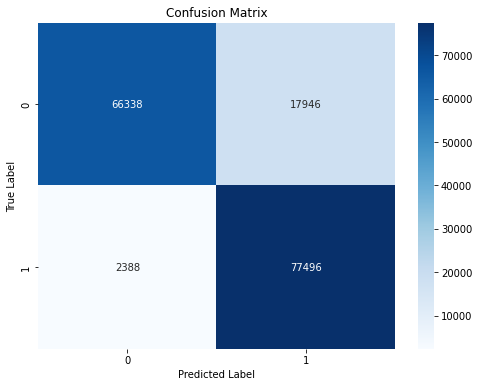

In [28]:
# Detect anomalies
anomaly_indices, _ = detect_anomalies(vae, nf, test_loader, 2.5)

# Initialize an array for predictions
predictions = [0] * len(test_loader.dataset)  # Initialize all as normal
for idx in anomaly_indices:
    predictions[idx] = 1  # Mark as anomaly

# True labels
actual_labels = test_df['class3'].values  # Replace 'label' with the actual label column name

# Calculate metrics
accuracy = accuracy_score(actual_labels, predictions)
precision = precision_score(actual_labels, predictions)
recall = recall_score(actual_labels, predictions)
f1 = f1_score(actual_labels, predictions)
roc_auc = roc_auc_score(actual_labels, predictions)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'roc_auc Score: {roc_auc}')

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming actual_labels and predictions are defined
cm = confusion_matrix(actual_labels, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [30]:
cm

array([[ 36180,   5962],
       [ 23341, 334971]], dtype=int64)

In [32]:
test_df2 = pd.read_csv('df_testing.csv')

cm

In [33]:
# Replace 'normal' with 0 and 'attack' with 1 in the last column
#test_df['class3'] = test_df['class3'].replace({'normal': 0, 'attack': 1})

# Now proceed with separating features and labels
X_test2 = test_df2.iloc[:, :-1].values
y_test2= test_df2['class3'].values

# Convert to PyTorch tensors
X_test_tensor2 = torch.tensor(X_test2, dtype=torch.float32)
y_test_tensor2 = torch.tensor(y_test2, dtype=torch.long)

# Create a TensorDataset
test_dataset2 = TensorDataset(X_test_tensor2, y_test_tensor2)

# Create a DataLoader
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)


In [27]:
# Detect anomalies
anomaly_indices, _ = detect_anomalies(vae, nf, test_loader2,2.5)

# Initialize an array for predictions
predictions = [0] * len(test_loader2.dataset)  # Initialize all as normal
for idx in anomaly_indices:
    predictions[idx] = 1  # Mark as anomaly

# True labels
actual_labels = test_df['class3'].values  # Replace 'label' with the actual label column name

# Calculate metrics
accuracy = accuracy_score(actual_labels, predictions)
precision = precision_score(actual_labels, predictions)
recall = recall_score(actual_labels, predictions)
f1 = f1_score(actual_labels, predictions)
roc_auc = roc_auc_score(actual_labels, predictions)
# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'roc_auc Score: {roc_auc}')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming actual_labels and predictions are defined
cm = confusion_matrix(actual_labels, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'test_loader2' is not defined

In [62]:
cm


array([[36252,  5890],
       [ 1288, 38654]], dtype=int64)

Processed file: FSGM-XAAE-IIoT.csv
Accuracy: 0.7076319800698212, Precision: 0.8853277781167467, Recall: 0.6357405738320565, F1 Score: 0.7400571959416383
roc_auc Score: 0.7398246317501604


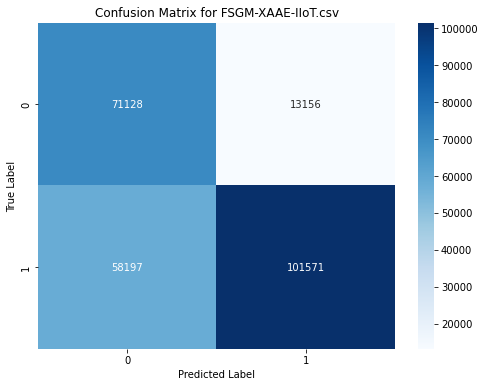

Processed file: BIM-XAAE-IIoT.csv
Accuracy: 0.9356243751331683, Precision: 0.9226999841550225, Recall: 0.984108206900005, F1 Score: 0.952415278236297
roc_auc Score: 0.9139135310993785


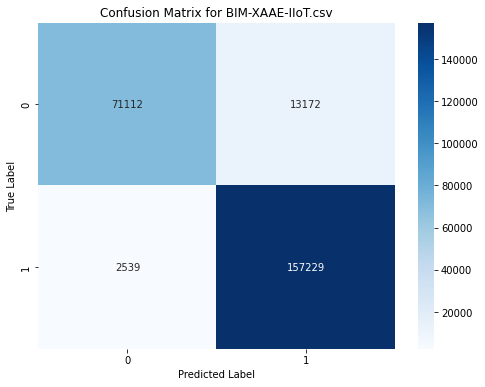

Processed file: DF-XAAE-IIoT.csv
Accuracy: 0.9346860505138249, Precision: 0.9226704752500853, Recall: 0.9825809924390366, F1 Score: 0.9516837925494832
roc_auc Score: 0.9132389087296033


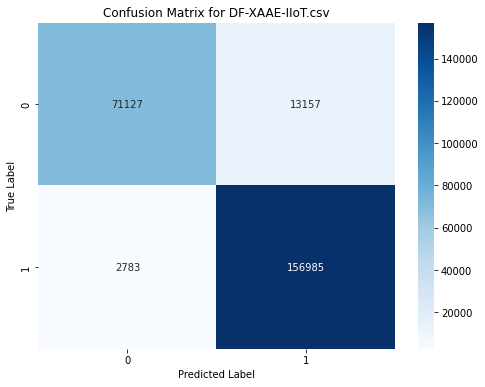

Processed file: JSMA-XAAE-IIoT.csv
Accuracy: 0.9219920344844541, Precision: 0.9212262343757482, Recall: 0.963202894196585, F1 Score: 0.9417470380887105
roc_auc Score: 0.903537994960283


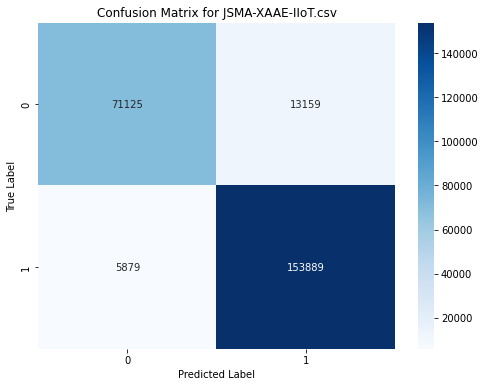

Processed file: CW2-XAAE-IIoT.csv
Accuracy: 0.7023953911461491, Precision: 0.8841308047010694, Recall: 0.6276538480797156, F1 Score: 0.7341364403398379
roc_auc Score: 0.7358643214106518


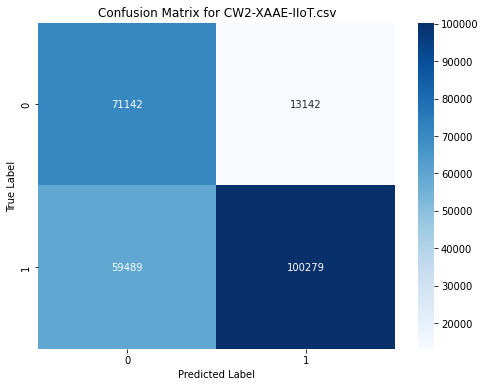

Processed file: CWinf-XAAE-IIoT.csv
Accuracy: 0.9185255601265304, Precision: 0.9208607119647628, Recall: 0.9578639026588553, F1 Score: 0.9389979015572654
roc_auc Score: 0.900910025459749


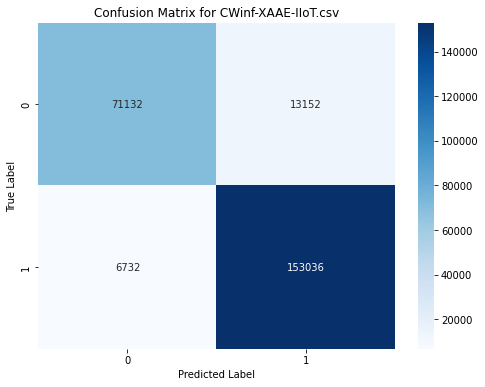

In [26]:

# Files to process
files_to_process = [
    'FSGM-XAAE-IIoT.csv',
    'BIM-XAAE-IIoT.csv',
    'DF-XAAE-IIoT.csv','JSMA-XAAE-IIoT.csv','CW2-XAAE-IIoT.csv','CWinf-XAAE-IIoT.csv'
    # Add more file names as needed
]

ref_file = 'df_testing.csv'
ref_df = pd.read_csv(ref_file)

# Initialize MinMaxScaler
scaler = MinMaxScaler()



for file_name in files_to_process:
    # Load and concatenate with ref_file
    df = pd.read_csv(file_name)
    df.columns = ref_df.columns
    concatenated_df = pd.concat([ref_df, df], ignore_index=True)
    
    # Apply MinMax scaling
    X_scaled = scaler.fit_transform(concatenated_df.iloc[:, :-1])
    y_true = concatenated_df.iloc[:, -1].values  # Adjust the column index/name as necessary
    
    # Convert to tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_true, dtype=torch.long)
    
    # Create DataLoader
    data_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=False)
    
    # Detect anomalies
    anomaly_indices, _ = detect_anomalies(vae, nf, data_loader, threshold=2.5)
    
    # Initialize predictions
    predictions = [0] * len(y_true)
    for idx in anomaly_indices:
        predictions[idx] = 1  # Mark as anomaly
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)
    roc_auc = roc_auc_score(y_true, predictions)

    # Print metrics
    print(f'Processed file: {file_name}')
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')
    print(f'roc_auc Score: {roc_auc}')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {file_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
